# Tracking the bond change

In [ ]:
from rdkit import Chem
from rdkit.Chem import rdChemReactions

def _bonds_from_template(template_mol, kekulize=False):
    """
    Extract bonds between mapped atoms from a template molecule.
    Returns: dict {(atom1_mapNum, atom2_mapNum): rdkit.Chem.rdchem.BondType}
    """
    # work on a copy to optionally kekulize safely

    copy_mol = Chem.Mol(template_mol)

    if kekulize:
        try:
            Chem.Kekulize(copy_mol, clearAromaticFlags=True)
        except Exception:
            # fallback if kekulization fails; just keep as is
            pass

    idx_to_map = {}
    for a in copy_mol.GetAtoms():
        m = a.GetAtomMapNum()
        if m:  # >0 means mapped, since we don't really care the unmapped atoms (neglected in matrix)
            idx_to_map[a.GetIdx()] = m

    edge2type = {}
    for b in copy_mol.GetBonds():
        a1, a2 = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        if a1 in idx_to_map and a2 in idx_to_map:
            i, j = sorted((idx_to_map[a1], idx_to_map[a2])) # record the bond mapping number instead of the atom index
            edge2type[(i, j)] = b.GetBondType()
    return edge2type


def summarize_bond_changes(rxn, kekulize=False):
    """
    Given an rdChemReactions.ChemicalReaction, report which bonds are formed,
    broken, or change order, based on template differences.
    """
    # union across all reactant templates
    r_edge2type = {}
    for i in range(rxn.GetNumReactantTemplates()):
        tmpl = rxn.GetReactantTemplate(i) #rdkit.Chem.rdchem.Mol object
        r_edge2type.update(_bonds_from_template(tmpl, kekulize=kekulize))

    # union across all product templates
    p_edge2type = {}
    print(rxn.GetNumProductTemplates())
    for i in range(rxn.GetNumProductTemplates()):
        tmpl = rxn.GetProductTemplate(i) #rdkit.Chem.rdchem.Mol object
        p_edge2type.update(_bonds_from_template(tmpl, kekulize=kekulize))

    # print(r_edge2type)

    r_edges = set(r_edge2type)
    p_edges = set(p_edge2type)

    print(r_edges)
    print(p_edges)

    broken = sorted(r_edges - p_edges)              # present only in reactants
    formed = sorted(p_edges - r_edges)              # present only in products
    common = r_edges & p_edges

    order_changes = [
        (e, r_edge2type[e], p_edge2type[e])
        for e in sorted(common)
        if r_edge2type[e] != p_edge2type[e]
    ]

    return {
        "broken": [(e, r_edge2type[e]) for e in broken],
        "formed": [(e, p_edge2type[e]) for e in formed],
        "order_changes": order_changes,
    }


In [ ]:

# Atom-mapped reaction SMARTS: C–Br + HO- → C–O + Br-
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
rxn = rdChemReactions.ReactionFromSmarts("[C&H3:1][C:2]1=[C:3]([N:4]([C:5]([C&H1:6]2[C&H2:7][C&H2:8][S:9](=[O:12])(=[O:13])[C&H2:10][C&H2:11]2)=[O:14])[C&H2:15][C:16]([O:35]CC)=[O:29])[C:30]([C&H3:31])=[C&H1:32][C&H1:33]=[C&H1:34]1.[NH2:17][C:18]1=[CH:19][CH:20]=[C:21]([C:22]2=[N:23][O:24][CH:25]=[N:26]2)[CH:27]=[CH:28]1\
                                   >>[CH3:1][C:2]1=[C:3]([N:4]([C:5]([CH:6]2[CH2:7][CH2:8][S:9](=[O:12])(=[O:13])[CH2:10][CH2:11]2)=[O:14])[CH2:15][C:16]([NH:17][C:18]2=[CH:19][CH:20]=[C:21]([C:22]3=[N:23][O:24][CH:25]=[N:26]3)[CH:27]=[CH:28]2)=[O:29])[C:30]([CH3:31])=[CH:32][CH:33]=[CH:34]1")
changes = summarize_bond_changes(rxn)
print("Broken:", changes["broken"])
print("Formed:", changes["formed"])
print("Order changes:", changes["order_changes"])
img = Draw.ReactionToImage(rxn)
img.save("rxn_to_target.png")


### Stereocenter
rdkit:
* Bond.GetStereo()
* Mol.GetStereoGroups()
* Chem.Lipinski.NumAtomStereoCenters()


In [3]:
from rdkit import Chem
from rdkit.Chem import Lipinski
from rdkit.Chem.Draw import IPythonConsole

IPythonConsole.drawOptions.addStereoAnnotation = True

# stereo_test = '[C&H3:1][C:2]([C&H3:3])([C&H3:4])/[C&H1:5]=[C:6](\\[C:7]#[N:8])[C:9](=[O:10])[N:11]1[C&H2:12][C&H2:13][C&H2:14][C@@&H1:15]([n:16]2[n:17][c:18](-[c:19]3[c&H1:20][c&H1:21][c:22]([O:23][c:24]4[c&H1:25][c&H1:26][c&H1:27][c&H1:28][c&H1:29]4)[c&H1:30][c:31]3[F:32])[c:33]3[c:34]([N&H2:35])[n:36][c&H1:37][n:38][c:39]23)[C&H2:40]1'
stereo_test = 'C[C@H]1[C@@H]2[C@@H]3CCC(=O)N3CCC[C@@H]2OC1=O'
mol = Chem.MolFromSmiles(stereo_test)

# Lipinski.NumAtomStereoCenters(mol)# it cannot get the result correctly if" &"" is presented in the SMARTS string
for b in mol.GetBonds():
    if b.GetStereo() != 0:
        print('bond index:', b.GetIdx(), 'bond BeginAtom AtomMapNum:', b.GetBeginAtom().GetAtomMapNum(), 'bond EndAtom AtomMapNum:',b.GetEndAtom().GetAtomMapNum())
        print('stereo type:', b.GetStereo())


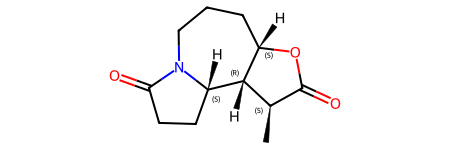

In [4]:
mol

### chirality

In [6]:
for a in mol.GetAtoms():
    if a.GetChiralTag() != 0:
        print('atom MAP number:', a.GetAtomMapNum(), 'atom index:', a.GetIdx())


atom MAP number: 0 atom index: 1
atom MAP number: 0 atom index: 2
atom MAP number: 0 atom index: 3
atom MAP number: 0 atom index: 12


In [ ]:
# Lipinski.NumUnspecifiedAtomStereoCenters(mol)